Загрузим нужные библиотеки

In [1]:
! python -m spacy download ru_core_news_sm

                                              0.0/15.3 MB ? eta -:--:--
                                              0.0/15.3 MB 1.3 MB/s eta 0:00:12
                                             0.0/15.3 MB 653.6 kB/s eta 0:00:24
                                             0.1/15.3 MB 871.5 kB/s eta 0:00:18
                                             0.1/15.3 MB 798.9 kB/s eta 0:00:19
                                             0.2/15.3 MB 984.6 kB/s eta 0:00:16
                                              0.2/15.3 MB 1.1 MB/s eta 0:00:14
                                              0.3/15.3 MB 1.3 MB/s eta 0:00:12
     -                                        0.4/15.3 MB 1.3 MB/s eta 0:00:12
     -                                        0.5/15.3 MB 1.5 MB/s eta 0:00:11
     -                                        0.6/15.3 MB 1.5 MB/s eta 0:00:10
     -                                        0.7/15.3 MB 1.6 MB/s eta 0:00:09
     --                                       0.8/15.3 

In [2]:
import pandas as pd
import unicodedata
import re
import spacy
import json
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import json
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# Подготовка данных

Загрузим данные

In [3]:
data = pd.read_csv('csv\\full_df.csv', sep=';')
data.head(3)
data = data.drop(columns='Unnamed: 0', axis=1)

Отфильтруем тексты по количеству символов. Оставим только 100+.

In [4]:
data['text_len'] = data.loc[:, 'text'].apply(lambda x: len(x))
data_filtered_by_text_len = data.query('text_len > 100')
print(f'Количество постов с 100+ символами: {data_filtered_by_text_len.shape[0]}')
data_filtered_by_text_len.head(3)

Количество постов с 100+ символами: 8556


,status,url,text,likes,reposts,comments,text_len
0,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,Всем привет!Выпустил свою первую статью на хаб...,17.0,0.0,0.0,295
1,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",6.0,0.0,2.0,117
2,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",17.0,6.0,0.0,117


Оставим только тексты содержащие кириллицу

In [5]:
data_cyrillic = data_filtered_by_text_len[data_filtered_by_text_len['text'].apply(lambda x: re.match(r'[А-Яа-я]+', x) is not None)]

print(f'Текстов на кириллице: {data_cyrillic.shape[0]}')
data_cyrillic.head(3)

Текстов на кириллице: 1960


,status,url,text,likes,reposts,comments,text_len
0,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,Всем привет!Выпустил свою первую статью на хаб...,17.0,0.0,0.0,295
1,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",6.0,0.0,2.0,117
2,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",17.0,6.0,0.0,117


Удалим дубликаты текстов

In [6]:
data_dd = data_cyrillic.drop_duplicates('text')
print(f'Осталось {data_dd.shape[0]} строк')
data_dd.head(3)

Осталось 1862 строк


,status,url,text,likes,reposts,comments,text_len
0,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,Всем привет!Выпустил свою первую статью на хаб...,17.0,0.0,0.0,295
1,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",6.0,0.0,2.0,117
6,Talent Acquisition Manager | Recruitment Lead ...,https://www.linkedin.com/in/dariaivanova,С трепетом готов представить свой продукт. Реф...,8.0,0.0,0.0,841


In [7]:
data_dd.shape

(1862, 7)

# Подготовка к моделированию

In [8]:
texts = data_dd["text"].tolist()
texts[0]

'Всем привет!Выпустил свою первую статью на хабр!https://lnkd.in/dt9N6D7BСтатья про историю и технологии разработки игры https://guess-word.com и как мы создали игру с элементами машинного обучения и вышли в ноль за 2 месяцаПри\xa0внимательном прочтении вы даже сможете запустить первую версию игры!'

In [9]:
len(texts)

1862

Проведем лемматизацию

In [10]:
if os.path.exists('lemmas.json'):
    with open("lemmas.json") as f:
        data_lemmatized = json.load(f)['lemmas']
else:
    model = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])
    data_lemmatized = []
    for doc in model.pipe(texts, disable=["tagger", "parser"]):
        data_lemmatized.append([token.lemma_ for token in doc])

    with open("lemmas.json", "w") as fid:
        json.dump({"lemmas": data_lemmatized}, fid)

print(data_lemmatized[0])

['всем', 'привет!выпустил', 'свой', 'первый', 'статья', 'на', 'хабр!https://lnkd.in', '/', 'dt9n6d7bстатья', 'про', 'история', 'и', 'технология', 'разработка', 'игра', 'https://guess-word.com', 'и', 'как', 'мы', 'создать', 'игра', 'с', 'элемент', 'машинный', 'обучение', 'и', 'выйти', 'в', 'ноль', 'за', '2', 'месяцапри', '\xa0', 'внимательный', 'прочтение', 'вы', 'даже', 'смочь', 'запустить', 'первый', 'версия', 'игра', '!']


In [11]:
len(data_lemmatized)

1862

Очистим тексты от ненужных символов

In [12]:
word_pattern = re.compile("^[а-я]*$")

def remove_symbols(doc):
    return [token for token in doc if word_pattern.match(token)]

data_words = list(map(remove_symbols, data_lemmatized))
print(data_words[0])

['всем', 'свой', 'первый', 'статья', 'на', 'про', 'история', 'и', 'технология', 'разработка', 'игра', 'и', 'как', 'мы', 'создать', 'игра', 'с', 'элемент', 'машинный', 'обучение', 'и', 'выйти', 'в', 'ноль', 'за', 'месяцапри', 'внимательный', 'прочтение', 'вы', 'даже', 'смочь', 'запустить', 'первый', 'версия', 'игра']


In [13]:
len(data_words)

1862

Загрузим русские стоп-слова

In [14]:
stop_words = stopwords.words('russian')
stop_words += ['это', 'свой', 'очень', 'мочь', 'ваш', 'наш']

Определим функцию для удаления стоп-слов

In [15]:
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

Применим функцию для удаления стоп-слов

In [16]:
len(data_words)

1862

In [17]:
data_words_nostops = remove_stopwords(data_words)

In [18]:
len(data_words_nostops)

1862

In [19]:
id2word = corpora.Dictionary(data_words_nostops)

texts = data_words_nostops

corpus = [id2word.doc2bow(text) for text in texts]

In [20]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('версия', 1),
  ('внимательный', 1),
  ('всем', 1),
  ('выйти', 1),
  ('запустить', 1),
  ('игра', 3),
  ('история', 1),
  ('машинный', 1),
  ('месяцапри', 1),
  ('ноль', 1),
  ('обучение', 1),
  ('первый', 2),
  ('прочтение', 1),
  ('разработка', 1),
  ('смочь', 1),
  ('создать', 1),
  ('статья', 1),
  ('технология', 1),
  ('элемент', 1)]]

# Протестируем моделирование с 20 темами

In [21]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=20, 
    random_state=765,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
    )

In [22]:
lda_model.print_topics()

[(0,
  '0.217*"пост" + 0.019*"защита" + 0.017*"единственный" + 0.017*"продавец" + 0.011*"стоять" + 0.009*"заработать" + 0.006*"покупатель" + 0.005*"автомобиль" + 0.005*"кол" + 0.002*"свитер"'),
 (1,
  '0.032*"минута" + 0.031*"попасть" + 0.029*"рекомендовать" + 0.029*"реализовать" + 0.026*"школа" + 0.023*"очередной" + 0.022*"отсутствие" + 0.022*"начинаться" + 0.021*"семья" + 0.021*"нормальный"'),
 (2,
  '0.048*"одну" + 0.046*"подкаст" + 0.030*"которыми" + 0.023*"перейти" + 0.014*"праздник" + 0.012*"познакомиться" + 0.011*"замечательный" + 0.011*"страничка" + 0.009*"музыка" + 0.003*"экосистема"'),
 (3,
  '0.078*"рассказывать" + 0.048*"зрение" + 0.030*"другими" + 0.014*"восприятие" + 0.014*"исполнитель" + 0.012*"александр" + 0.010*"взаимодействовать" + 0.009*"вероятность" + 0.005*"неожиданный" + 0.005*"видение"'),
 (4,
  '0.040*"мечта" + 0.037*"требовать" + 0.027*"верить" + 0.024*"игра" + 0.024*"счастливый" + 0.020*"публикация" + 0.018*"двигаться" + 0.013*"попросить" + 0.013*"довольный" +

Вычислим сложность и согласованность модели

In [23]:
print('Perplexity: ', lda_model.log_perplexity(corpus))

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -16.289506735300908
Coherence Score:  0.442760065331451


Отобразим результаты моделирования

In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.306421  0.250023       1        1  20.853381
18     0.320543 -0.030791       2        1  20.457524
17     0.327777  0.099377       3        1  18.999776
8      0.208847 -0.321958       4        1  11.616708
12     0.165740 -0.120132       5        1   9.792153
14    -0.030080 -0.002581       6        1   3.537320
13    -0.030141  0.003518       7        1   3.463260
6     -0.042225  0.005982       8        1   2.599372
5     -0.086228  0.009914       9        1   1.431492
7     -0.090252  0.010260      10        1   1.388030
19    -0.095462  0.010314      11        1   1.110306
1     -0.099093  0.010352      12        1   1.081685
16    -0.104205  0.009999      13        1   0.687411
0     -0.104365  0.009969      14        1   0.643294
10    -0.105946  0.009821      15        1   0.607264
4     -0.106267  0.009779      16        1   0.595388
3     -0.107643  0.009498      17        1   0.444568
2     -0.108191  0.009361      18        1   0.361974
11    -0.109508  0.008824      19        1   0.227240
9     -0.109723  0.008472      20        1   0.101854, topic_info=           Term         Freq        Total Category  logprob  loglift
236      работа  1798.000000  1798.000000  Default   30.000  30.0000
87      человек  1058.000000  1058.000000  Default   29.000  29.0000
119        опыт   710.000000   710.000000  Default   28.000  28.0000
169       новый   948.000000   948.000000  Default   27.000  27.0000
193      проект   732.000000   732.000000  Default   26.000  26.0000
...         ...          ...          ...      ...      ...      ...
9169         ми     0.006265     0.967527  Topic20   -9.713   1.8496
2444   материал     0.006265     0.967571  Topic20   -9.713   1.8496
5638   название     0.006265     0.967495  Topic20   -9.713   1.8497
4073     самому     0.006265     0.967465  Topic20   -9.713   1.8497
2043  нравиться     0.006265     0.967535  Topic20   -9.713   1.8496

[843 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1559     14  0.749892     автомобиль
1068     11  0.970495          автор
220      15  0.942481      агентство
1241     10  0.804947  администратор
1780     20  0.781528           айти
...     ...       ...            ...
1545      9  0.961770  эффективность
155       4  0.280848    эффективный
155       6  0.712922    эффективный
1392      6  0.989805       являться
219       7  0.995728           язык

[625 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 19, 18, 9, 13, 15, 14, 7, 6, 8, 20, 2, 17, 1, 11, 5, 4, 3, 12, 10])

# Подбор количества тем

Подберем количество тем основываясь на согласованности модели

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics, 
            random_state=765,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True
            )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
#model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_nostops, start=1, limit=10, step=1)

In [27]:
# limit=10
# start=1
# step=1
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

Наилучший результат показала модель с 3 темами

In [28]:
def model_scorer(data):
    id2word = corpora.Dictionary(data)

    texts = data

    corpus = [id2word.doc2bow(text) for text in texts]

    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=3, 
        random_state=765,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
        )

    print('Perplexity: ', lda_model.log_perplexity(corpus))

    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score: ', coherence_lda)

    return lda_model, corpus, id2word

best_model, best_corpus, best_id2word = model_scorer(data_words_nostops)

Perplexity:  -8.381390061581836
Coherence Score:  0.5966520391095856


In [29]:
best_model.print_topics()

[(0,
  '0.017*"работа" + 0.011*"компания" + 0.008*"проект" + 0.008*"новый" + 0.008*"опыт" + 0.007*"команда" + 0.006*"данных" + 0.006*"весь" + 0.005*"возможность" + 0.005*"разработка"'),
 (1,
  '0.017*"з" + 0.010*"що" + 0.007*"як" + 0.006*"ми" + 0.005*"це" + 0.004*"буде" + 0.004*"час" + 0.003*"але" + 0.003*"якщо" + 0.003*"роботи"'),
 (2,
  '0.012*"человек" + 0.008*"весь" + 0.007*"время" + 0.007*"год" + 0.005*"нужный" + 0.005*"делать" + 0.005*"жизнь" + 0.004*"день" + 0.004*"работа" + 0.004*"работать"')]

# Использование биграмм и триграмм

Проверим, повлияет ли использование биграмм и триграмм на согласованность модели

In [30]:
bigram = gensim.models.Phrases(data_words_nostops, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words_nostops], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [31]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)

In [32]:
model_scorer(data_words_bigrams)
print('Complete')

Perplexity:  -8.434334494421696
Coherence Score:  0.439582008213859
Complete


In [33]:
model_scorer(data_words_trigrams)
print('Complete')

Perplexity:  -8.429958224926464
Coherence Score:  0.5836013461964166
Complete


Использование биграмм и триграмм только ухудшили согласованнось

# Анализ наилучшей модели

In [34]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, best_corpus, best_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.163100  0.125427       1        1  54.146368
2     -0.063423 -0.168545       2        1  40.627477
1      0.226523  0.043119       3        1   5.226155, topic_info=          Term        Freq       Total Category  logprob  loglift
46    компания  629.000000  629.000000  Default  30.0000  30.0000
87     человек  568.000000  568.000000  Default  29.0000  29.0000
7842         з   92.000000   92.000000  Default  28.0000  28.0000
193     проект  453.000000  453.000000  Default  27.0000  27.0000
45     команда  375.000000  375.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
8667    багато    8.966265    9.593106   Topic3  -6.3846   2.8839
9910     зараз    9.056113    9.689467   Topic3  -6.3747   2.8839
902        час   19.442024   93.664742   Topic3  -5.6107   1.3792
97        день   14.133790  241.625384   Topic3  -5.9295   0.1127
413      робот    9.912367   30.353676   Topic3  -6.2843   1.8324

[182 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
7841      3  0.958037       або
8500      3  0.955864       але
454       1  0.996770    анализ
690       1  0.999779  аналитик
8667      3  0.938174    багато
...     ...       ...       ...
8649      3  0.990614        що
8650      3  0.987770       щоб
8530      3  0.988441        як
8867      3  0.941401      який
8532      3  0.962928      якщо

[203 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [35]:
topic_probs = best_model.get_document_topics(best_corpus)
max_prob_topics = list(map(lambda doc_probs: max(doc_probs, key=lambda x: x[1])[0], topic_probs))

In [36]:
df = pd.DataFrame([list(data_dd["text"]), max_prob_topics]).transpose()
df.columns = ['text', 'topic_label']
df.head(3)

,text,topic_label
0,Всем привет!Выпустил свою первую статью на хаб...,0
1,"Если вам интересно позалипать в слова, я запус...",2
2,С трепетом готов представить свой продукт. Реф...,0


In [37]:
df.loc[df['topic_label'] == 1].head()

,text,topic_label
159,"Юрий Бура (@juriy), спасибо! Это были очень кр...",1
306,"Штош, надоело мне в IT. Уволюсь и открою пивну...",1
336,Компания первой создавший и распространивший э...,1
607,Дизайн и верстка. Земельные участки Подмосковь...,1
609,Лендинг пейдж для службы вскрытия дверей. #web...,1


In [38]:
best_model.show_topic(2)

[('человек', 0.012023695),
 ('весь', 0.007881439),
 ('время', 0.0067690583),
 ('год', 0.0065009254),
 ('нужный', 0.0050492613),
 ('делать', 0.004994253),
 ('жизнь', 0.0047352044),
 ('день', 0.004474903),
 ('работа', 0.0042895307),
 ('работать', 0.00423403)]

# Вывод

С имеющимися данными наилучшую согласованность имеет модель с разделением на 3 темы. После разделения на 3 темы было выявлено, что как отдельная тема выделены тексты на украинском языке. Для получения нормальных результатов нужно провести повторное моделирование исключив из данных украинские тексты.

# Анализ с исключением украинских постов

Сбросим индексы

In [48]:
df = df.reset_index(drop=True)
df.head()

,text,topic_label
0,Всем привет!Выпустил свою первую статью на хаб...,0
1,"Если вам интересно позалипать в слова, я запус...",2
2,С трепетом готов представить свой продукт. Реф...,0
3,Всем привет! Мы в AppFollow ищем Senior DevOps...,0
4,На следующей неделе российская data-практика E...,0


In [49]:
data_dd = data_dd.reset_index(drop=True)
data_dd.head()

,status,url,text,likes,reposts,comments,text_len
0,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,Всем привет!Выпустил свою первую статью на хаб...,17.0,0.0,0.0,295
1,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",6.0,0.0,2.0,117
2,Talent Acquisition Manager | Recruitment Lead ...,https://www.linkedin.com/in/dariaivanova,С трепетом готов представить свой продукт. Реф...,8.0,0.0,0.0,841
3,Talent Acquisition Manager | Recruitment Lead ...,https://www.linkedin.com/in/dariaivanova,Всем привет! Мы в AppFollow ищем Senior DevOps...,12.0,4.0,6.0,1233
4,Talent Acquisition Manager | Recruitment Lead ...,https://www.linkedin.com/in/dariaivanova,На следующей неделе российская data-практика E...,11.0,0.0,0.0,539


Отфильтруем посты от украинских

In [57]:
df_wu = df.loc[df['topic_label'] != 1]
display(df_wu.shape)
wu_indexes = df_wu.index

(1710, 2)

In [58]:
data_dd_wu = data_dd.loc[wu_indexes]

In [59]:
data_words_wu = [data_words_nostops[i] for i in wu_indexes]
len(data_words_wu)

1710

Подготовка к моделированию

In [61]:
id2word_wu = corpora.Dictionary(data_words_wu)

texts_wu = data_words_wu

corpus_wu = [id2word_wu.doc2bow(text) for text in texts_wu]

Определим оптимальное количество постов

In [62]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics, 
            random_state=765,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True
            )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [79]:
limit=16
start=9
step=1

In [80]:
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word_wu, 
    corpus=corpus_wu, 
    texts=data_words_wu, 
    start=start, 
    limit=limit, 
    step=step
    )

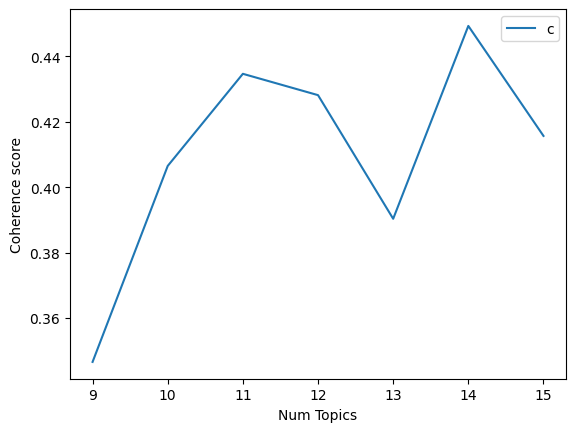

In [81]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [82]:
def model_scorer(data, topics_cnt):
    id2word = corpora.Dictionary(data)

    texts = data

    corpus = [id2word.doc2bow(text) for text in texts]

    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=topics_cnt, 
        random_state=765,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
        )

    print('Perplexity: ', lda_model.log_perplexity(corpus))

    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score: ', coherence_lda)

    return lda_model, corpus, id2word

In [83]:
best_model_wu, best_corpus_wu, best_id2word_wu = model_scorer(data_words_wu, 14)

Perplexity:  -12.605366232657266
Coherence Score:  0.48892843571015315


In [84]:
best_model_wu.print_topics()

[(0,
  '0.139*"пост" + 0.065*"итог" + 0.037*"напиши" + 0.032*"дата" + 0.030*"другими" + 0.021*"александр" + 0.019*"почитать" + 0.017*"плохой" + 0.015*"личка" + 0.012*"метод"'),
 (1,
  '0.067*"мной" + 0.046*"кейс" + 0.044*"встреча" + 0.034*"различный" + 0.029*"учиться" + 0.017*"заявка" + 0.015*"насколько" + 0.012*"пробовать" + 0.011*"лето" + 0.010*"вилка"'),
 (2,
  '0.017*"машинный" + 0.011*"заняться" + 0.007*"пачка" + 0.004*"клик" + 0.004*"доверительный" + 0.002*"скучный" + 0.001*"интервал" + 0.000*"курить" + 0.000*"шкала" + 0.000*"тренд"'),
 (3,
  '0.043*"вакансия" + 0.031*"позиция" + 0.031*"резюме" + 0.027*"кандидат" + 0.026*"дизайнер" + 0.026*"предложение" + 0.024*"сессия" + 0.024*"поиск" + 0.023*"период" + 0.022*"английский"'),
 (4,
  '0.052*"работа" + 0.035*"компания" + 0.024*"проект" + 0.021*"данных" + 0.021*"опыт" + 0.019*"команда" + 0.013*"разработка" + 0.012*"модель" + 0.011*"новый" + 0.010*"система"'),
 (5,
  '0.037*"отзыв" + 0.031*"исследование" + 0.023*"стратегия" + 0.022*"

In [139]:
result_df = pd.DataFrame([list(data_dd_wu["text"])]).transpose()
result_df.columns = ['text']

def shapenhead(data):
    display(data.shape)
    display(data.head(3))

shapenhead(result_df)

(1710, 1)

,text
0,Всем привет!Выпустил свою первую статью на хаб...
1,"Если вам интересно позалипать в слова, я запус..."
2,С трепетом готов представить свой продукт. Реф...


In [140]:
# Вывод номеров тем с пороговой вероятностью
topics = []
for topic in best_model_wu.get_document_topics(best_corpus_wu):
    t = []
    for n in topic:
        t.append(n[0])
    topics.append(t)

topics = pd.DataFrame(topics)
shapenhead(topics)

(1710, 12)

,0,1,2,3,4,5,6,7,8,9,10,11
0,2,3,4,6,8.0,10.0,12.0,13.0,NaN,NaN,NaN,NaN
1,0,3,4,5,6.0,8.0,12.0,13.0,NaN,NaN,NaN,NaN
2,3,4,6,9,12.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
result_df_topics = pd.concat([result_df, topics], axis=1)
shapenhead(result_df_topics)

(1710, 13)

,text,0,1,2,3,4,5,6,7,8,9,10,11
0,Всем привет!Выпустил свою первую статью на хаб...,2,3,4,6,8.0,10.0,12.0,13.0,NaN,NaN,NaN,NaN
1,"Если вам интересно позалипать в слова, я запус...",0,3,4,5,6.0,8.0,12.0,13.0,NaN,NaN,NaN,NaN
2,С трепетом готов представить свой продукт. Реф...,3,4,6,9,12.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
topics_dict = {
    0: "Статьи и методы",
    1: "Обучение и опыт",
    2: "Машинное обучение и статистика",
    3: "Вакансии и резюме",
    4: "Работа и проекты",
    5: "Исследования и стратегии",
    6: "Карьера и развитие",
    7: "Психология и рекомендации",
    8: "Тестирование и навыки",
    9: "Собеседование и сообщество",
    10: "Стажировка и мечты",
    11: "Продажи и бизнес",
    12: "Общие темы",
    13: "Жизнь и цели"
}

columns = [0,1,2,3,4,5,6,7,8,9,10,11]
for i in columns:
    result_df_topics[i] = result_df_topics[i].map(topics_dict)

shapenhead(result_df_topics)

(1710, 13)

,text,0,1,2,3,4,5,6,7,8,9,10,11
0,Всем привет!Выпустил свою первую статью на хаб...,Машинное обучение и статистика,Вакансии и резюме,Работа и проекты,Карьера и развитие,Тестирование и навыки,Стажировка и мечты,Общие темы,Жизнь и цели,NaN,NaN,NaN,NaN
1,"Если вам интересно позалипать в слова, я запус...",Статьи и методы,Вакансии и резюме,Работа и проекты,Исследования и стратегии,Карьера и развитие,Тестирование и навыки,Общие темы,Жизнь и цели,NaN,NaN,NaN,NaN
2,С трепетом готов представить свой продукт. Реф...,Вакансии и резюме,Работа и проекты,Карьера и развитие,Собеседование и сообщество,Общие темы,Жизнь и цели,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
reactions = data_dd_wu[['likes', 'reposts', 'comments']]
shapenhead(reactions)

(1710, 3)

,likes,reposts,comments
0,17.0,0.0,0.0
1,6.0,0.0,2.0
2,8.0,0.0,0.0


In [149]:
reactions = reactions.fillna(0)
reactions.isna().sum()

likes       0
reposts     0
comments    0
dtype: int64

In [161]:
reactions['likes'] = reactions['likes'].astype(str).apply(lambda x: x.split(',')[0]).apply(lambda x: x.split('.')[0])\
    .apply(lambda x: x.replace(" ", "")).astype(int)
reactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1710 entries, 0 to 1861
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   likes     1710 non-null   int32  
 1   reposts   1710 non-null   float64
 2   comments  1710 non-null   float64
dtypes: float64(2), int32(1)
memory usage: 46.8 KB


In [162]:
reactions['sum'] = reactions[['likes', 'reposts', 'comments']].sum(axis=1)
shapenhead(reactions)

(1710, 4)

,likes,reposts,comments,sum
0,17,0.0,0.0,17.0
1,6,0.0,2.0,8.0
2,8,0.0,0.0,8.0


In [163]:
result_df_topics = pd.concat([result_df_topics, reactions['sum']], axis=1)
shapenhead(result_df_topics)

(1854, 14)

,text,0,1,2,3,4,5,6,7,8,9,10,11,sum
0,Всем привет!Выпустил свою первую статью на хаб...,Машинное обучение и статистика,Вакансии и резюме,Работа и проекты,Карьера и развитие,Тестирование и навыки,Стажировка и мечты,Общие темы,Жизнь и цели,NaN,NaN,NaN,NaN,17.0
1,"Если вам интересно позалипать в слова, я запус...",Статьи и методы,Вакансии и резюме,Работа и проекты,Исследования и стратегии,Карьера и развитие,Тестирование и навыки,Общие темы,Жизнь и цели,NaN,NaN,NaN,NaN,8.0
2,С трепетом готов представить свой продукт. Реф...,Вакансии и резюме,Работа и проекты,Карьера и развитие,Собеседование и сообщество,Общие темы,Жизнь и цели,NaN,NaN,NaN,NaN,NaN,NaN,8.0


Количество тектов по темам

In [185]:
result_df_topics.loc[result_df_topics[1].notna()].groupby(1).count().reset_index()[[1, 'text']]

,1,text
0,Вакансии и резюме,839
1,Исследования и стратегии,1
2,Карьера и развитие,1
3,Машинное обучение и статистика,19
4,Обучение и опыт,230
5,Работа и проекты,620


In [190]:
topics_count = result_df_topics.loc[result_df_topics[0].notna()].groupby(0).count().reset_index()[[0, 'text']]
for i in range(1, 12):
    n = result_df_topics.loc[result_df_topics[i].notna()].groupby(i).count().reset_index()[[i, 'text']].rename(columns={i: 0})
    topics_count = pd.concat([topics_count, n], axis=0)

topics_count

,0,text
0,Вакансии и резюме,620
1,Машинное обучение и статистика,18
2,Обучение и опыт,181
3,Работа и проекты,2
4,Статьи и методы,889
...,...,...
1,Общие темы,15
2,Продажи и бизнес,1
0,Жизнь и цели,15
1,Общие темы,1


In [194]:
topics_count = topics_count.groupby(0).sum().reset_index().rename(columns={0: 'topic_name', 'text': 'texts_count'})
topics_count

,topic_name,texts_count
0,Вакансии и резюме,1707
1,Жизнь и цели,1710
2,Исследования и стратегии,765
3,Карьера и развитие,1687
4,Машинное обучение и статистика,42
5,Обучение и опыт,411
6,Общие темы,1710
7,Продажи и бизнес,242
8,Психология и рекомендации,391
9,Работа и проекты,1710


In [195]:
topics_count.to_csv('topics_count.csv', index=False)

Охват

In [196]:
result_df_topics

,text,0,1,2,3,4,5,6,7,8,9,10,11,sum
0,Всем привет!Выпустил свою первую статью на хаб...,Машинное обучение и статистика,Вакансии и резюме,Работа и проекты,Карьера и развитие,Тестирование и навыки,Стажировка и мечты,Общие темы,Жизнь и цели,NaN,NaN,NaN,NaN,17.0
1,"Если вам интересно позалипать в слова, я запус...",Статьи и методы,Вакансии и резюме,Работа и проекты,Исследования и стратегии,Карьера и развитие,Тестирование и навыки,Общие темы,Жизнь и цели,NaN,NaN,NaN,NaN,8.0
2,С трепетом готов представить свой продукт. Реф...,Вакансии и резюме,Работа и проекты,Карьера и развитие,Собеседование и сообщество,Общие темы,Жизнь и цели,NaN,NaN,NaN,NaN,NaN,NaN,8.0
3,Всем привет! Мы в AppFollow ищем Senior DevOps...,Обучение и опыт,Вакансии и резюме,Работа и проекты,Исследования и стратегии,Карьера и развитие,Стажировка и мечты,Общие темы,Жизнь и цели,NaN,NaN,NaN,NaN,22.0
4,На следующей неделе российская data-практика E...,Обучение и опыт,Машинное обучение и статистика,Вакансии и резюме,Работа и проекты,Карьера и развитие,Тестирование и навыки,Общие темы,Жизнь и цели,NaN,NaN,NaN,NaN,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
1858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0
1859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
1860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


# Заключение

В ходе анализа собранных текстов было выявлено, что исходные данные с наибольшей согласованностью делятся на 3 темы. Одной из тем являются тексты на украинском языке.

Наличие большого количества одинаковых слов в двух языках ухудшает результаты моделирования. Было принято решение убрать из данных украинские тексты.

